In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.datasets import co2

from datadata import utils
from prevision import addDates,addSportBroadcast

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
df_sales=pd.read_csv("prevision/data/daily_sales.csv",parse_dates=['Date'] ,index_col='Date').rename_axis('date')
df_meteo=pd.read_csv("prevision/data/meteo.csv",parse_dates=['time'],index_col='time').rename_axis('date').drop('Unnamed: 0',axis=1)
df_predictHQ=pd.read_csv("prevision/data/affluence.csv",parse_dates=['date'],index_col='date')
df_all=pd.merge(pd.merge(df_sales, df_meteo, on='date'), df_predictHQ, on='date').reset_index().dropna()
df_all=addDates(df_all)
df_all = addSportBroadcast(df_all)
df_all

,date,vente,apparent_temperature_max,apparent_temperature_min,sunset,uv_index_max,rain_sum,showers_sum,snowfall_sum,precipitation_hours,...,day_3,day_4,day_5,day_6,vacance,ferie,match_mma,match_nba,match_nfl,match_nhl
0,2023-09-15,12222.69,20.1,8.0,19.10,5.40,0.00,0.0,0.0,0.0,...,False,True,False,False,0,False,0,0,0,0
1,2023-09-14,11244.54,14.5,11.4,19.13,3.90,0.00,0.0,0.0,0.0,...,True,False,False,False,0,False,0,0,0,0
2,2023-09-13,6514.32,23.4,15.2,19.17,4.75,36.75,0.0,0.0,4.0,...,False,False,False,False,0,False,1,0,0,0
3,2023-09-12,5708.35,23.9,14.5,19.18,4.55,0.00,0.0,0.0,0.0,...,False,False,False,False,0,False,1,0,0,0
4,2023-09-11,3031.55,23.4,15.5,19.22,5.65,0.00,0.0,0.0,0.0,...,False,False,False,False,0,False,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,2023-02-15,4655.16,3.4,-6.6,18.33,2.80,1.70,0.0,0.0,4.0,...,False,False,False,False,0,False,0,0,0,0
219,2023-02-14,7026.25,0.6,-6.7,18.32,3.45,0.00,0.0,0.0,0.0,...,False,False,False,False,0,False,0,0,0,1
220,2023-02-13,3152.95,-0.0,-10.6,18.28,3.60,0.00,0.0,0.0,0.0,...,False,False,False,False,0,False,0,0,0,0
221,2023-02-12,13013.24,-1.4,-9.0,18.27,3.65,0.00,0.0,0.0,0.0,...,False,False,False,True,0,False,1,0,0,1


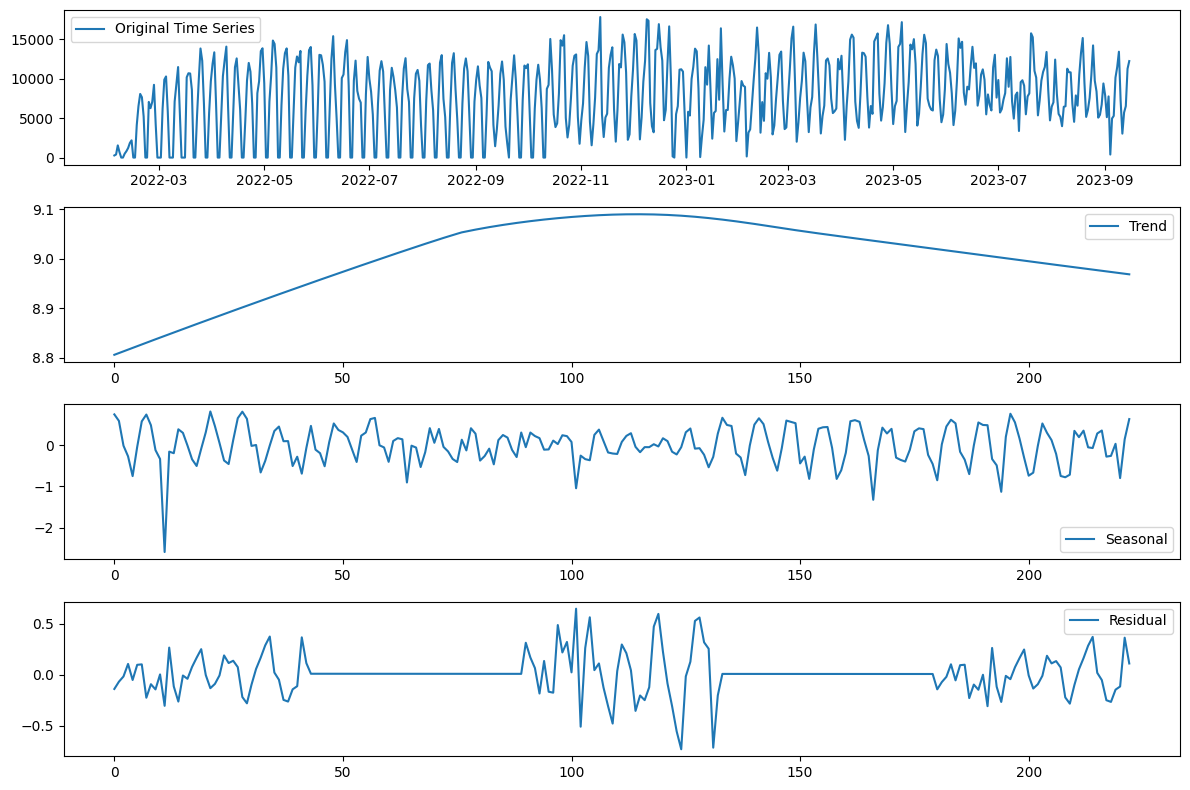

In [4]:
sales_data_non_zero = df_all['vente'].replace(0, np.nan).dropna()
log_sales = np.log(sales_data_non_zero)
stl = STL(log_sales, seasonal=13,period=30*3)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the original time series and the components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df_sales['vente'], label='Original Time Series')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
class WindowGeneratorNoFuture():
    def __init__(self, X, Y, input_sequence_length=14, output_sequence_length=7):
        self.X=X
        self.Y=Y
        self.input_sequence_length = input_sequence_length
        self.output_sequence_length = output_sequence_length
        
        assert (len(self.X) - self.input_sequence_length - self.output_sequence_length + 1 > 0), \
            f'Dataset size too small for current options\ndata:{len(self.X)}, ' \
            f'input_sequence_length:{input_sequence_length}, output_sequence_length:{output_sequence_length}'

    def __len__(self):  # number of windows we can generate to work it must be at least 1
        return len(self.X) - self.input_sequence_length - self.output_sequence_length + 1

    def __getitem__(self, idx):
        x=np.concatenate(
            (self.X[idx:idx + self.input_sequence_length], self.Y[idx:idx + self.input_sequence_length][:, None]),1)
        y = self.Y[
            idx + self.input_sequence_length:idx + self.input_sequence_length + self.output_sequence_length]
        return x, y

def split_data_based_on_duration(data, duration_months):
    last_date = data['date'].max()
    cutoff_date = last_date - pd.DateOffset(months=duration_months)
    train_data = data[data['date'] <= cutoff_date]
    validation_data = data[data['date'] > cutoff_date]
    return train_data, validation_data

def getXY(data,input_sequence_length=14, output_sequence_length=7):
    x=data.drop(['date','vente'],axis=1).values
    y=data['vente'].values
    win=WindowGeneratorNoFuture(x,y,input_sequence_length, output_sequence_length)
    newX=[]
    newY=[]
    for i in range(len(win)):
        newX.append(win[i][0].flatten('F'))
        newY.append(win[i][1])
    return newX,newY
    
def plot_eval_result(eval_results):
    # Extract training and validation losses
    train_loss = eval_results['validation_0']['rmse']
    val_loss = eval_results['validation_1']['rmse']

    # Plot the loss
    epochs = len(train_loss)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Validation RMSE: 2833.5326001228673
best params
 subsample n_estimators max_depth learning_rate colsample_bytree


/Users/carlos/PycharmProjects/dionysos/venv/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


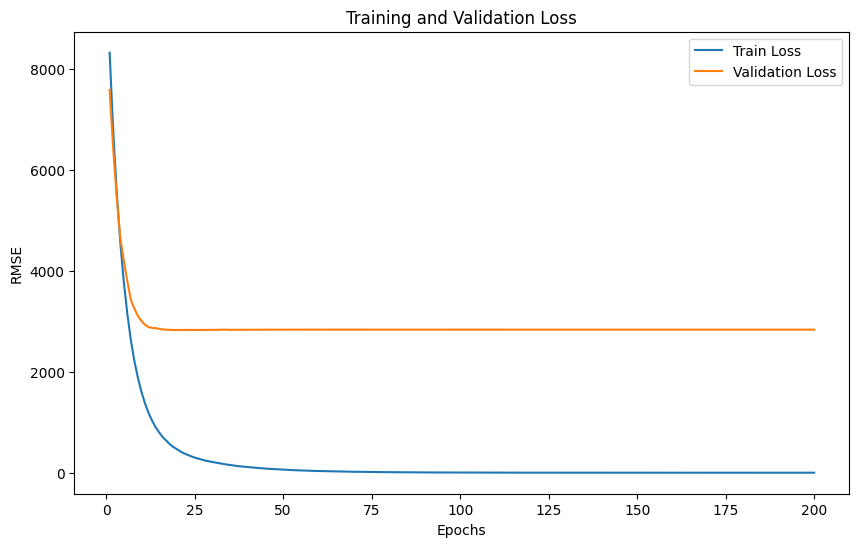

In [8]:
sales_data=df_all
train_data_1yr, validation_data_1yr = split_data_based_on_duration(sales_data, 12)
train_data_6mo, validation_data_6mo = split_data_based_on_duration(sales_data, 6)
train_data_3mo, validation_data_3mo = split_data_based_on_duration(sales_data, 3)

train_data_1yr.reset_index(drop=True, inplace=True)
validation_data_1yr.reset_index(drop=True, inplace=True)
train_data_6mo.reset_index(drop=True, inplace=True)
validation_data_6mo.reset_index(drop=True, inplace=True)
train_data_3mo.reset_index(drop=True, inplace=True)
validation_data_3mo.reset_index(drop=True, inplace=True)

input_sequence_length=14
output_sequence_length=7
X_train,Y_train=getXY(train_data_3mo)
X_test,Y_test=getXY(validation_data_3mo)

param_space = {
    'n_estimators': np.arange(50, 300, 50),  # Number of boosting rounds
    'max_depth': np.arange(3, 10),  # Maximum depth of the tree
    'learning_rate': np.arange(0.05, 0.31, 0.05),  # Learning rate
    'subsample': np.arange(0.7, 1.0, 0.1),  # Subsample ratio
    'colsample_bytree': np.arange(0.7, 1.0, 0.1),  # Subsample ratio of columns
}
xgb_regressor = xgb.XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(xgb_regressor, param_distributions=param_space,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=3,
                                   random_state=42, verbose=1, n_jobs=-1)

random_search.fit(X_train, Y_train)
best_model = random_search.best_estimator_
val_preds = best_model.predict(X_test)
val_rmse = np.sqrt(mean_squared_error(Y_test, val_preds))
print('Validation RMSE:', val_rmse)
mean_absolute_error(Y_test, val_preds)
print('best params\n',*random_search.best_params_)

best_model.fit(X_train, Y_train,
               eval_set=[(X_train, Y_train), (X_test, Y_test)],
               eval_metric='rmse',
               verbose=0)
eval_results = best_model.evals_result()
res = best_model.predict(X_test)
plot_eval_result(eval_results)


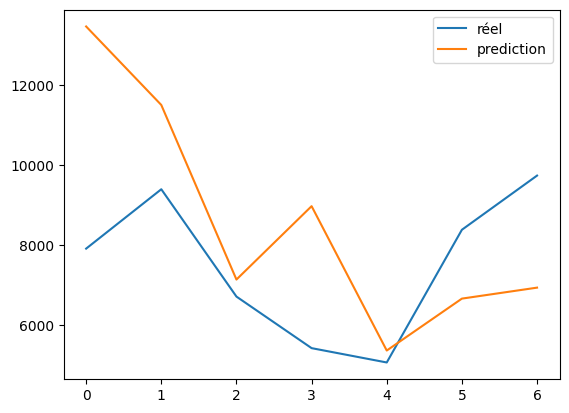

In [9]:
plt.plot(Y_test[0],label='réel')
plt.plot(res[0],label='prediction')
plt.legend()
plt.show()


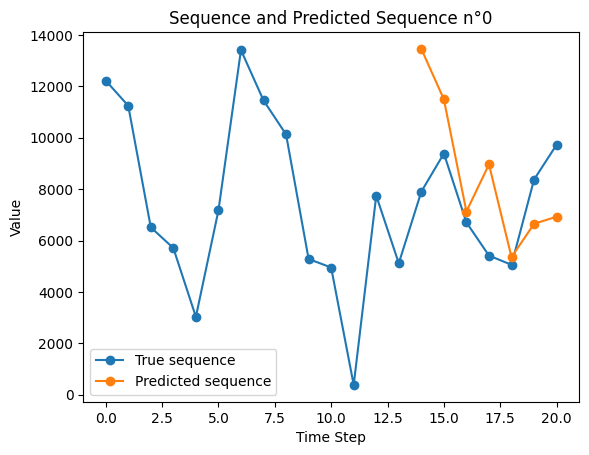

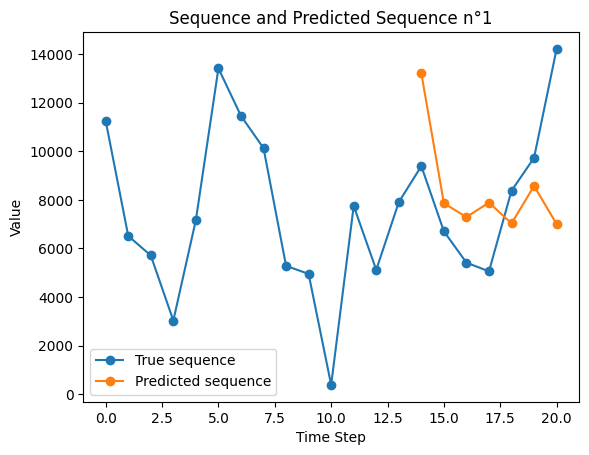

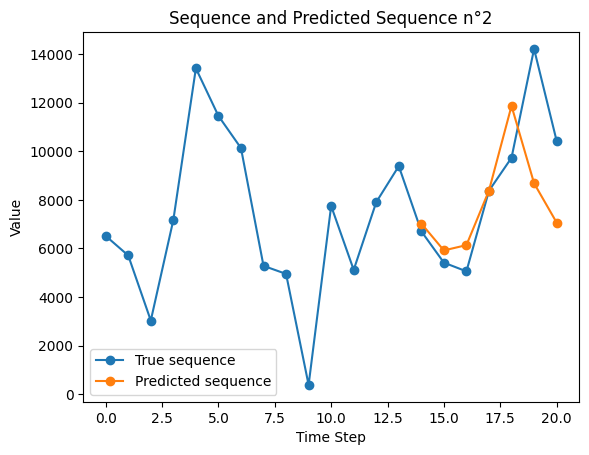

In [10]:
ntest=3
for i in range(ntest):
    history_sequence=X_test[i][-input_sequence_length:]
    target_sequence=Y_test[i]
    predicted_sequence=res[i]
    plt.plot(range(input_sequence_length + output_sequence_length),
        np.concatenate((history_sequence, target_sequence)), label='True sequence',
        linestyle="-", marker="o")
    plt.plot(range(input_sequence_length, input_sequence_length + output_sequence_length),
        predicted_sequence, linestyle="-", marker="o", label='Predicted sequence')
    plt.legend()
    plt.title(f'Sequence and Predicted Sequence n°{i}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()

In [15]:
def feature_importance(best_model, X_train):
    """
    Calcule et affiche l'importance des fonctionnalités du modèle.

    Arguments:
    - best_model : meilleur modèle entraîné
    - X_train : données d'entraînement (features)
    """
    # Obtenir l'importance des fonctionnalités
    importance = best_model.feature_importances_
    print(len(importance))
    # Triez les fonctionnalités par importance décroissante
    feature_names = df_all.columns.tolist()
    print(feature_names)
    
    # Regrouper l'importance des day_0, day_1, day_2, day_3, day_4, day_5, day_6 en une seule colonne day
    day_0_index = feature_names.index('day_0')
    day_importance = np.sum(importance[day_0_index:day_0_index + 7])
    importance[day_0_index] = day_importance
    importance = np.delete(importance, range(day_0_index + 1, day_0_index + 7))
    feature_names = np.delete(feature_names, range(day_0_index + 1, day_0_index + 7))
    feature_names[day_0_index] = 'day'

    # Lister les fonctionnalités par importance décroissante
    feature_names = feature_names.tolist()
    feature_names = np.array(feature_names)
    indices = np.argsort(importance)[::-1]

    # Tracer le graphique de l'importance des fonctionnalités
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importance)), importance[indices], tick_label=feature_names[indices].tolist())
    plt.xticks(rotation=90)
    plt.xlabel('Fonctionnalités')
    plt.ylabel('Importance')
    plt.title('Importance des fonctionnalités')
    plt.show()

feature_importance(best_model, X_train)

392
['date', 'vente', 'apparent_temperature_max', 'apparent_temperature_min', 'sunset', 'uv_index_max', 'rain_sum', 'showers_sum', 'snowfall_sum', 'precipitation_hours', 'attendance_concerts', 'attendance_conferences', 'attendance_expos', 'attendance_festivals', 'attendance_performing_arts', 'attendance_sports', 'day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'vacance', 'ferie', 'match_mma', 'match_nba', 'match_nfl', 'match_nhl']


IndexError: index 228 is out of bounds for axis 0 with size 23

<Figure size 1000x600 with 0 Axes>